# Analysis of tblCardData

This notebook contains codes and functions to run queries to analyze and understand the data present in the table `tblCardData` of the xspoc database.

In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [20]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt

# Project Library
from dbconnection.postgresql import PostgresRDS

## Querying

Use the function `run_query(*args)` to get run queries from the table. Some examples are given below

&nbsp;

**Get list of unique WellNames in the dataset**

Query Time: *1m 30s*
```
SELECT DISTINCT("NodeID") 
FROM xspoc_dbo."tblCardData"
ORDER BY "NodeID"
```



&nbsp;

**Get Card Data**

To get any sort of Card data (bytea dtype) use the following mapping `encode("tblCardData"."CardColumn", 'hex') as cardcolumn`.

An Example for importing `DownholeCardB` and `SurfaceCardB` from well `K2 Holdings` will be:

```
SELECT 
"NodeID",
"Date",
encode("tblCardData"."DownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,
FROM xspoc_dbo."tblCardData"
WHERE "NodeID" = 'K2 Holdings'
ORDER BY "NodeID" , "Date" 
```

In [16]:
def run_query(sql, engine):
    data = pd.read_sql(sql, con=engine)
    return data

def get_dyna(card_arr):
    """
    Transforms Hexadecimal Dyna Card Value into Position and Load value
    Logic for Client1 dyna cards
    :param card_arr: Hexadecimal Array
    :return: Position, Load 2D array
    """
    if pd.isnull(card_arr):
        pos = [0, 0, 0]
        load = [0, 0, 0]

    else:
#         test_card = card_arr[2:].strip()
        test_card = card_arr
        display(len(test_card))
        mid = len(test_card) / 2
        mid = int(mid)

        load = []
        pos = []

        for i in range(0, mid, 8):
            load_temp = test_card[i:i + 8]
            load_int = struct.unpack('f', bytes.fromhex(load_temp))[0]
            load.append(load_int)

            pos_temp = test_card[mid + i:mid + i + 8]
            pos_int = struct.unpack('f', bytes.fromhex(pos_temp))[0]
            pos.append(pos_int)

    return np.column_stack(([pos, load]))

In [54]:
query = """
SELECT 
"NodeID",
"Date",
encode("tblCardData"."DownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard
FROM xspoc_dbo."tblCardData"
WHERE "NodeID" = 'K2 Holdings'
ORDER BY "NodeID" , "Date"
"""

with PostgresRDS() as engine:
    result = run_query(query, engine)

Connected to oasis-data DataBase
Connection Closed


In [57]:
result

,NodeID,Date,downcard,surfcard
0,K2 Holdings,1989-01-31 05:33:03,c820e746f392f7464a890247514c09479f941247c7f32d...,00902146000c264600902a4600202f4600c43346006838...
1,K2 Holdings,1989-02-03 07:05:04,None,0030224600d4264600902b46006430460054354600f439...
2,K2 Holdings,1989-04-02 17:52:18,None,005c234600f0274600802c46000431460098354600f039...
3,K2 Holdings,1989-09-08 05:33:04,None,0070264600002b4600882f46000c3446006c384600a83c...
4,K2 Holdings,2019-03-19 01:18:34,702c8e43d8f9a44388f2b843800bcb4320efdc43c8aef0...,00d09f4600ba9c4600dc9b4600889b4600a29c4600e29e...
...,...,...,...,...
3185,K2 Holdings,2020-05-25 19:37:32,00654bc3808f0842184c9243149308442478404484546b...,0044a6460056a8460066a746009aa74600b4a6460076a4...
3186,K2 Holdings,2020-05-26 03:37:34,None,0066a34600a0a24600f8a04600d69f4600509e46002e9d...
3187,K2 Holdings,2027-05-26 20:20:21,None,00fade460076e24600e4e5460066ea4600a0ee4600bcf1...
3188,K2 Holdings,2029-05-11 21:17:34,None,0094e046009ee146004ee246003ae34600fee4460082e7...


In [50]:
down_card = result.loc[9, 'downcard']
surf_card = result.loc[9, 'surfcard']

down_xy = get_dyna(down_card)
surf_xy = get_dyna(surf_card)

3200

3200

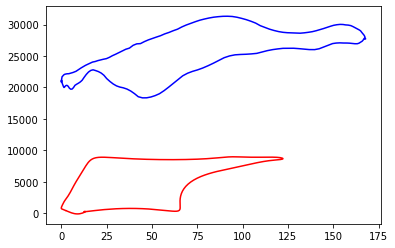

In [52]:
plt.plot(down_xy[:,0], down_xy[:, 1], c='r')
plt.plot(surf_xy[:,0], surf_xy[:, 1], c='b')